In [98]:
import math
import torch
import os, sys
import torchhd

# Note: this example requires the matplotlib library: https://matplotlib.org/stable/users/getting_started/
import matplotlib.pyplot as plt
from matplotlib import cm

## Functions for visualization

In [99]:
def plot_hist(ax, x, bins, range, density=False):
    count, edges = torch.histogram(x, bins=bins, range=range, density=density)
    bar_center = (edges[:-1] + edges[1:]) / 2
    bar_width =edges[1:] - edges[:-1]
    ax.bar(bar_center, count, width=bar_width)

In [100]:

# One-dimensional with several bandwidth values
def visualize_one_dimensional_bandwidth(
    fpe,
    values,
    ind,
    dp_b_05,
    dp_b_1,
    dp_b_2,
    dp_b_4,
    true_kernel_values=None,
    title_value="",
):
    values_rel = values - values[ind]
    fig, (ax0, ax) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
    # Visualize the phase distribution using the histogram of randomly chosen values accessible via fpe.weight
    plot_hist(ax0, fpe.weight, bins=51, range=(-torch.pi, torch.pi))
    ax0.set_xlabel("Phase values")
    ax0.set_ylabel("Frequency")
    ax0.set_title("Phase distribution")

    # Visualize the similarity curves for a value at ind
    if not true_kernel_values == None:
        ax.plot(
            values_rel,
            true_kernel_values,
            color="k",
            linewidth=2,
            linestyle="solid",
            label="True kernel",
        )
    ax.plot(
        values_rel,
        dp_b_05[:, ind],
        color="b",
        linestyle="dotted",
        label="Bandwidth=0.5",
    )
    ax.plot(
        values_rel,
        dp_b_1[:, ind],
        color="r",
        linestyle="dashed",
        label="Bandwidth=1.0",
    )
    ax.plot(
        values_rel,
        dp_b_2[:, ind],
        color="g",
        linestyle="dashdot",
        label="Bandwidth=2.0",
    )
    ax.plot(
        values_rel,
        dp_b_4[:, ind],
        color="m",
        linestyle="solid",
        label="Bandwidth=4.0",
    )
    ax.set_xlabel("Relative values")
    ax.set_ylabel("Similarity")
    ax.set_title("Similarity kernel")
    ax.axes.set_xbound(values_rel.min(), values_rel.max())
    ax.axes.set_ybound(-1.05, 1.05)
    ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', frameon=False)

    fig.suptitle(title_value)
    plt.show()


In [101]:

# Two-dimensional with several bandwidth values
def visualize_two_dimensional(fpe, x, y, valX, valY, z, title_value=""):
    levels = torch.linspace(-1.0, 1.0, 51)

    fig = plt.figure(tight_layout=True)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    # Visualize the phase distribution using the histogram of randomly chosen values accessible via fpe.weight
    ax0 = fig.add_subplot(131)
    
    img = ax0.hist2d(
        fpe.weight[:, 0].numpy(),
        fpe.weight[:, 1].numpy(),
        bins=31,
        density=True,
        range=((-1.01*torch.pi, 1.01*torch.pi), (-1.01*torch.pi, 1.01*torch.pi)),
        cmap=cm.viridis,
        vmin=0.0,
        vmax=1.0,
    )
    cbar = plt.colorbar(img[3], ax=ax0)
    ax0.axes.set_xbound(-torch.pi, torch.pi)
    ax0.axes.set_ybound(-torch.pi, torch.pi)
    ax0.set_xlabel("Phase values, 1st dimension")
    ax0.set_ylabel("Phase values, 2nd dimension")
    ax0.set_title("Phase distribution")
    ax0.set_aspect("equal")
    ax0.tick_params(axis="x")
    ax0.tick_params(axis="y")

    # Plot colormap
    ax1 = fig.add_subplot(132)
    img = ax1.contourf(
        x.numpy() - valX, y.numpy() - valY, z.numpy(), cmap=cm.viridis, levels=levels
    )
    cbar = plt.colorbar(img, ax=ax1)
    cbar.ax.tick_params()
    ax1.axes.set_xbound((x - valX).min(), (x - valX).max())
    ax1.axes.set_ybound((y - valY).min(), (y - valY).max())
    ax1.set_xlabel("Relative values")
    ax1.set_ylabel("Relative values")
    ax1.set_title("Kernel shape colormap")
    ax1.tick_params(axis="x")
    ax1.tick_params(axis="y")
    ax1.set_aspect("equal")

    # Plot 3D projection
    ax2 = fig.add_subplot(133, projection="3d")
    ax2.plot_surface(
        (x - valX).numpy(),
        (y - valY).numpy(),
        z.numpy(),
        cmap=cm.viridis,
        vmin=-1.0,
        vmax=1.0,
    )
    ax2.set_title("Kernel shape 3D projection")
    ax2.tick_params(axis="x")
    ax2.tick_params(axis="y")
    ax2.tick_params(axis="z")

    fig.suptitle(title_value)
    plt.show()

In [102]:
# Dimensionality of hypervectors
dimensions = 5000

## One-dimensional predefined kernels
values = torch.arange(start=0.1, end=10.0, step=0.05)
# index of the value of interest
val = 5.0
ind = (values == val).nonzero(as_tuple=True)[0]

## Complex valued representations with FHRR model

In [103]:
vsa_model = "FHRR"
norm_factor = dimensions

## Sinc kernel
kernel_shape = "sinc"
true_kernel_values = torch.sinc(values - val)


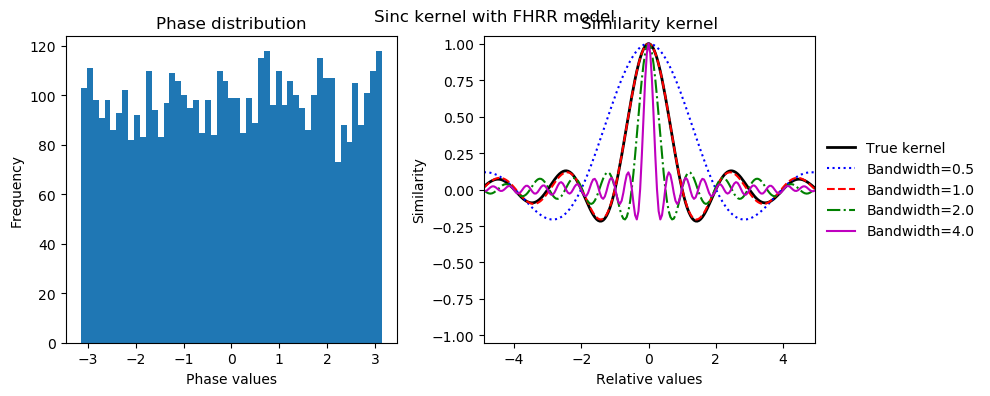

In [104]:
# Compute FPEs and their similarities for different values of bandwidth

# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    1, dimensions, distribution=kernel_shape, bandwidth=1.0, vsa=vsa_model
)
fpes = fpe(values.view(-1, 1))
dp_b_1 = fpes.dot_similarity(fpes) / dimensions

fpe.bandwidth = 0.5
fpes = fpe(values.view(-1, 1))
dp_b_05 = fpes.dot_similarity(fpes) / dimensions

fpe.bandwidth = 2.0
fpes = fpe(values.view(-1, 1))
dp_b_2 = fpes.dot_similarity(fpes) / dimensions

fpe.bandwidth = 4.0
fpes = fpe(values.view(-1, 1))
dp_b_4 = fpes.dot_similarity(fpes) / dimensions

# Visualize the results
visualize_one_dimensional_bandwidth(
    fpe,
    values,
    ind,
    dp_b_05,
    dp_b_1,
    dp_b_2,
    dp_b_4,
    true_kernel_values,
    "Sinc kernel with FHRR model",
)


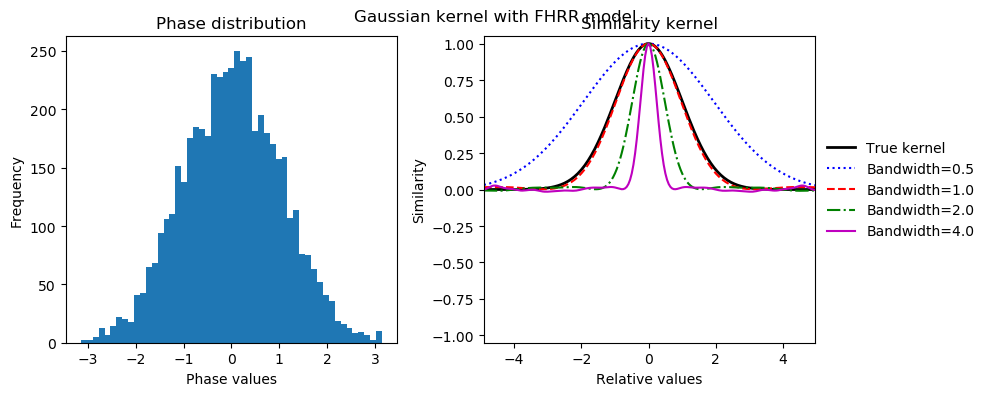

In [105]:
## Gaussian kernel
kernel_shape = "gaussian"
true_kernel_values = torch.exp(-(torch.pow(values - val, 2)) / 2)

# Compute FPEs and their similarities for different values of bandwidth

# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    1, dimensions, distribution=kernel_shape, bandwidth=1.0, vsa=vsa_model
)
fpes = fpe(values.view(-1, 1))
dp_b_1 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 0.5
fpes = fpe(values.view(-1, 1))
dp_b_05 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 2.0
fpes = fpe(values.view(-1, 1))
dp_b_2 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 4.0
fpes = fpe(values.view(-1, 1))
dp_b_4 = fpes.dot_similarity(fpes) / norm_factor

# Visualize the results
visualize_one_dimensional_bandwidth(
    fpe,
    values,
    ind,
    dp_b_05,
    dp_b_1,
    dp_b_2,
    dp_b_4,
    true_kernel_values,
    "Gaussian kernel with FHRR model",
)

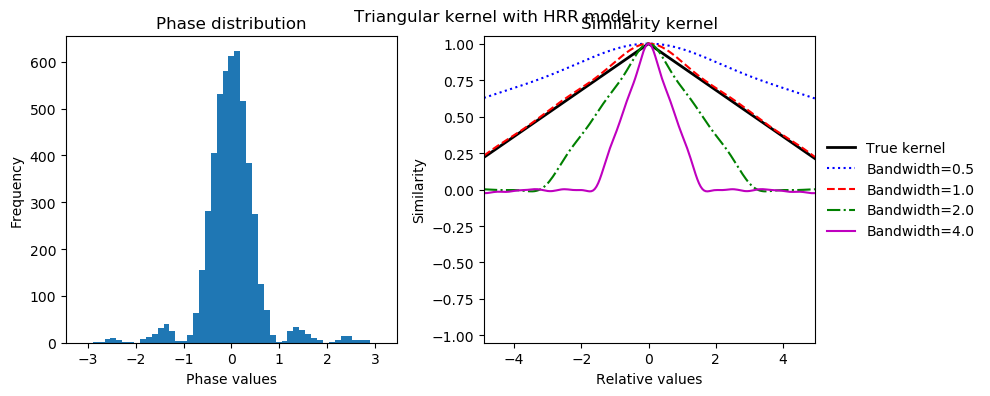

In [106]:

## Gaussian kernel

# Phase distribution for triangular kernel (squared sinc function)
class SquaredSincDistribution(torch.distributions.Distribution):
    def __init__(self, loc=0, scale=1):
        self.loc = loc  # Mean
        self.scale = scale  # Standard deviation

    def sinc(self, x):
        # squared sinc function implementation
        return torch.sinc(x)**2

    def sample(self, sample_shape=torch.Size()):
        sample_shape = torch.Size(sample_shape)
        # Rejection sampling from the squared sinc distribution using a proposal distribution (uniform in range -pi and pi)
        proposal_dist = torch.distributions.uniform.Uniform(-math.pi, math.pi)

        if sample_shape.numel() == 1:
            samples = proposal_dist.sample(sample_shape)
        else:
            samples = []

            while len(samples) < sample_shape.numel():
                proposed_samples = proposal_dist.sample(sample_shape)
                acceptance_prob = torch.rand(sample_shape)

                accepted_samples = proposed_samples[acceptance_prob < self.sinc((proposed_samples - self.loc) / self.scale)]
                samples.extend(accepted_samples.tolist())
            samples = torch.tensor(samples[:sample_shape.numel()])
            samples = torch.reshape(samples, sample_shape)

        return samples


kernel_shape = SquaredSincDistribution(0,1)
true_kernel_values = 1 - torch.abs(values - val) * 1 / (2 * math.pi)

# Compute FPEs and their similarities for different values of bandwidth

# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    1, dimensions, distribution=kernel_shape, bandwidth=1.0, vsa=vsa_model
)
fpes = fpe(values.view(-1, 1))
dp_b_1 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 0.5
fpes = fpe(values.view(-1, 1))
dp_b_05 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 2.0
fpes = fpe(values.view(-1, 1))
dp_b_2 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 4.0
fpes = fpe(values.view(-1, 1))
dp_b_4 = fpes.dot_similarity(fpes) / norm_factor

# Visualize the results
visualize_one_dimensional_bandwidth(
    fpe,
    values,
    ind,
    dp_b_05,
    dp_b_1,
    dp_b_2,
    dp_b_4,
    true_kernel_values,
    "Triangular kernel with HRR model",
)

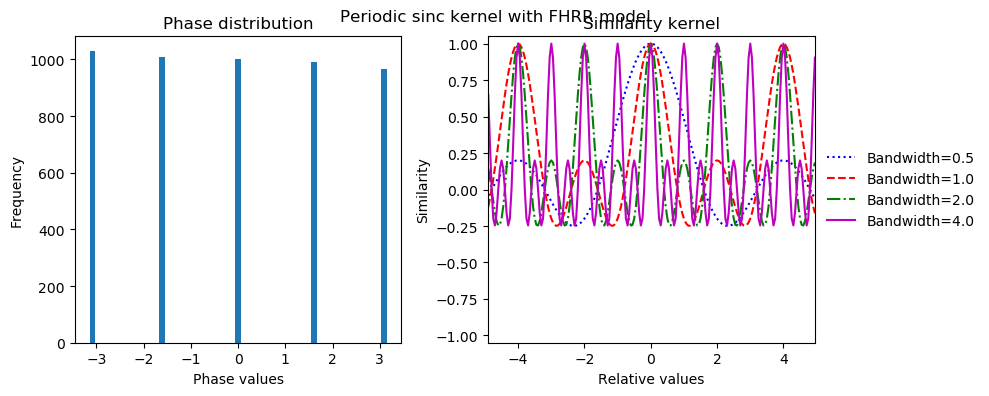

In [107]:
## Periodic Sinc kernel

# Phase distribution for periodic Sinc kernel
class SincDisc(torch.distributions.Categorical):
    def sample(self, sample_shape=torch.Size()):
        const = (self.probs.size(-1) - 1) / 2

        return math.pi * (super().sample(sample_shape) - const) / const


period = 5
kernel_shape = SincDisc(torch.ones(period))

# Compute FPEs and their similarities for different values of bandwidth

# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    1, dimensions, distribution=kernel_shape, bandwidth=1.0, vsa=vsa_model
)
fpes = fpe(values.view(-1, 1))
dp_b_1 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 0.5
fpes = fpe(values.view(-1, 1))
dp_b_05 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 2.0
fpes = fpe(values.view(-1, 1))
dp_b_2 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 4.0
fpes = fpe(values.view(-1, 1))
dp_b_4 = fpes.dot_similarity(fpes) / norm_factor

# Visualize the results
visualize_one_dimensional_bandwidth(
    fpe,
    values,
    ind,
    dp_b_05,
    dp_b_1,
    dp_b_2,
    dp_b_4,
    title_value="Periodic sinc kernel with FHRR model",
)

## Complex valued representations with HRR model

In [108]:
vsa_model = "HRR"
norm_factor = 1.0

## Sinc kernel
kernel_shape = "sinc"
true_kernel_values = torch.sinc(values - val)

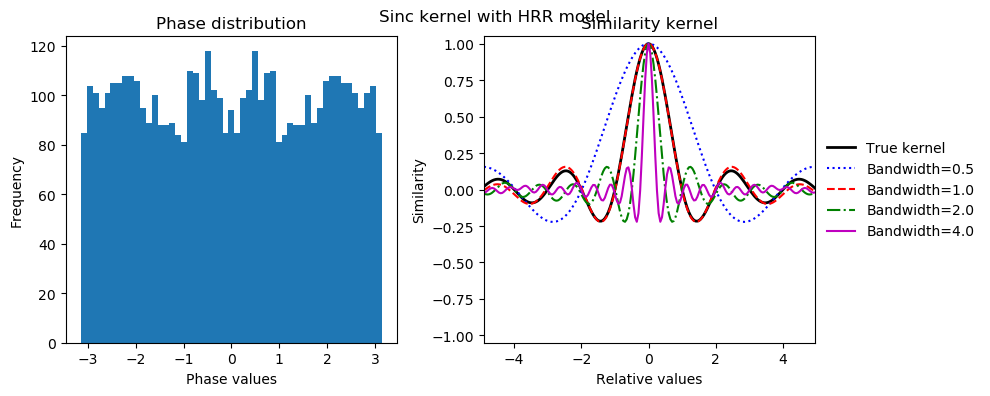

In [109]:
# Compute FPEs and their similarities for different values of bandwidth

# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    1, dimensions, distribution=kernel_shape, bandwidth=1.0, vsa=vsa_model
)
fpes = fpe(values.view(-1, 1))
dp_b_1 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 0.5
fpes = fpe(values.view(-1, 1))
dp_b_05 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 2.0
fpes = fpe(values.view(-1, 1))
dp_b_2 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 4.0
fpes = fpe(values.view(-1, 1))
dp_b_4 = fpes.dot_similarity(fpes) / norm_factor

# Visualize the results
visualize_one_dimensional_bandwidth(
    fpe,
    values,
    ind,
    dp_b_05,
    dp_b_1,
    dp_b_2,
    dp_b_4,
    true_kernel_values,
    "Sinc kernel with HRR model",
)


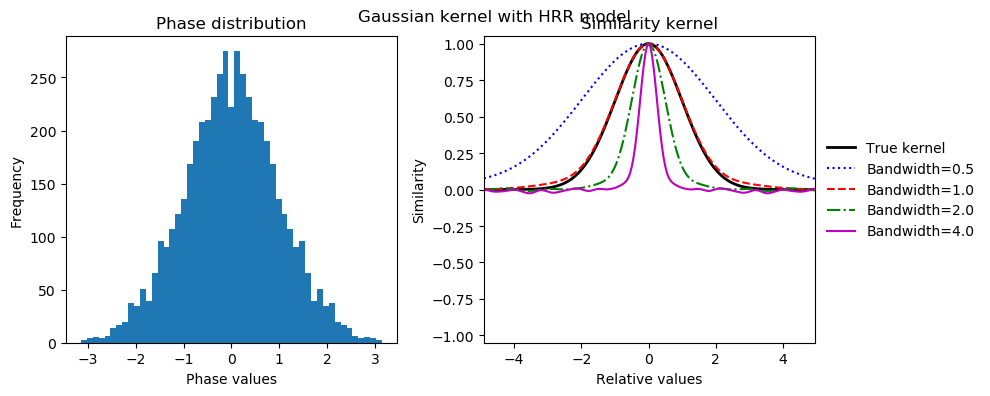

In [110]:

## Gaussian kernel
kernel_shape = "gaussian"
true_kernel_values = torch.exp(-(torch.pow(values - val, 2)) / 2)

# Compute FPEs and their similarities for different values of bandwidth

# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    1, dimensions, distribution=kernel_shape, bandwidth=1.0, vsa=vsa_model
)
fpes = fpe(values.view(-1, 1))
dp_b_1 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 0.5
fpes = fpe(values.view(-1, 1))
dp_b_05 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 2.0
fpes = fpe(values.view(-1, 1))
dp_b_2 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 4.0
fpes = fpe(values.view(-1, 1))
dp_b_4 = fpes.dot_similarity(fpes) / norm_factor

# Visualize the results
visualize_one_dimensional_bandwidth(
    fpe,
    values,
    ind,
    dp_b_05,
    dp_b_1,
    dp_b_2,
    dp_b_4,
    true_kernel_values,
    "Gaussian kernel with HRR model",
)

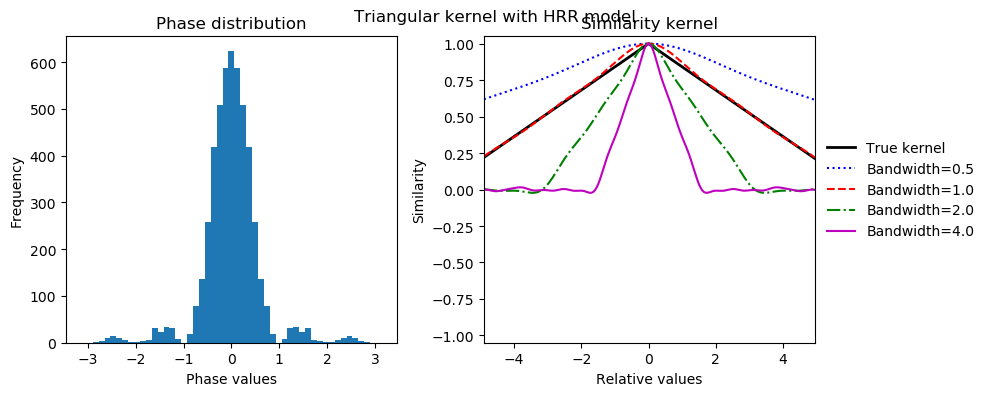

In [111]:

## Gaussian kernel

# Phase distribution for triangular kernel (squared sinc function)
class SquaredSincDistribution(torch.distributions.Distribution):
    def __init__(self, loc=0, scale=1):
        self.loc = loc  # Mean
        self.scale = scale  # Standard deviation

    def sinc(self, x):
        # squared sinc function implementation
        return torch.sinc(x)**2

    def sample(self, sample_shape=torch.Size()):
        sample_shape = torch.Size(sample_shape)
        # Rejection sampling from the squared sinc distribution using a proposal distribution (uniform in range -pi and pi)
        proposal_dist = torch.distributions.uniform.Uniform(-math.pi, math.pi)

        if sample_shape.numel() == 1:
            samples = proposal_dist.sample(sample_shape)
        else:
            samples = []

            while len(samples) < sample_shape.numel():
                proposed_samples = proposal_dist.sample(sample_shape)
                acceptance_prob = torch.rand(sample_shape)

                accepted_samples = proposed_samples[acceptance_prob < self.sinc((proposed_samples - self.loc) / self.scale)]
                samples.extend(accepted_samples.tolist())
            samples = torch.tensor(samples[:sample_shape.numel()])
            samples = torch.reshape(samples, sample_shape)

        return samples


kernel_shape = SquaredSincDistribution(0,1)
true_kernel_values = 1 - torch.abs(values - val) * 1 / (2 * math.pi)

# Compute FPEs and their similarities for different values of bandwidth

# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    1, dimensions, distribution=kernel_shape, bandwidth=1.0, vsa=vsa_model
)
fpes = fpe(values.view(-1, 1))
dp_b_1 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 0.5
fpes = fpe(values.view(-1, 1))
dp_b_05 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 2.0
fpes = fpe(values.view(-1, 1))
dp_b_2 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 4.0
fpes = fpe(values.view(-1, 1))
dp_b_4 = fpes.dot_similarity(fpes) / norm_factor

# Visualize the results
visualize_one_dimensional_bandwidth(
    fpe,
    values,
    ind,
    dp_b_05,
    dp_b_1,
    dp_b_2,
    dp_b_4,
    true_kernel_values,
    "Triangular kernel with HRR model",
)

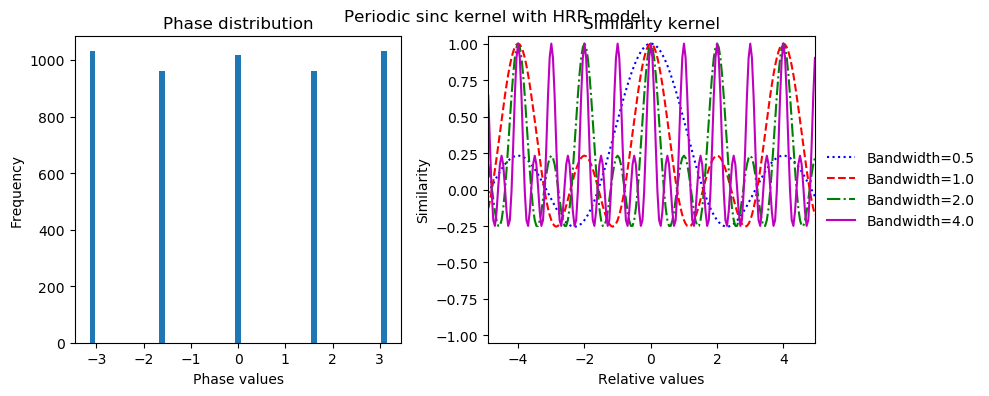

In [112]:

## Periodic Sinc kernel


# Phase distribution for periodic Sinc kernel
class SincDisc(torch.distributions.Categorical):
    def sample(self, sample_shape=torch.Size()):
        const = (self.probs.size(-1) - 1) / 2

        return math.pi * (super().sample(sample_shape) - const) / const


period = 5
kernel_shape = SincDisc(torch.ones(period))

# Compute FPEs and their similarities for different values of bandwidth

# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    1, dimensions, distribution=kernel_shape, bandwidth=1.0, vsa=vsa_model
)
fpes = fpe(values.view(-1, 1))
dp_b_1 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 0.5
fpes = fpe(values.view(-1, 1))
dp_b_05 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 2.0
fpes = fpe(values.view(-1, 1))
dp_b_2 = fpes.dot_similarity(fpes) / norm_factor

fpe.bandwidth = 4.0
fpes = fpe(values.view(-1, 1))
dp_b_4 = fpes.dot_similarity(fpes) / norm_factor

# Visualize the results
visualize_one_dimensional_bandwidth(
    fpe,
    values,
    ind,
    dp_b_05,
    dp_b_1,
    dp_b_2,
    dp_b_4,
    title_value="Periodic sinc kernel with HRR model",
)


## Two-dimensional predefined kernels

In [113]:
values = torch.arange(start=0.1, end=10.0, step=0.1)
x, y = torch.meshgrid(values, values, indexing="xy")
# All values to be represented
values_fpe = torch.cat(
    (torch.unsqueeze(torch.flatten(x), 1), torch.unsqueeze(torch.flatten(y), 1)), 1
)
# index of the value of interest
valX = 5.0
valY = 5.0
val_t = torch.tensor([valX, valY])
values_diff = (values_fpe - val_t).abs().sum(-1)
ind = (values_diff == 0).nonzero()


## Complex valued representations with FHRR model
vsa_model = "FHRR"
norm_factor = dimensions

## Sinc kernel
kernel_shape = "sinc"
band = 1.0

# Compute FPEs and their similarities for different values of bandwidth
# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    2, dimensions, distribution=kernel_shape, bandwidth=band, vsa=vsa_model
)
# Compute FPEs for all values
fpes = fpe(values_fpe)
# Compute similarities for the obtained FPEs
dot_product = fpes.dot_similarity(fpes) / norm_factor
# Get 2D grid for the visualization
z = torch.unflatten(dot_product[ind[0, 0], :], 0, x.shape)

# Visualize the results
visualize_two_dimensional(
    fpe, x, y, valX, valY, z, title_value="2D sinc kernel with FHRR model"
)


ValueError: Unknown projection '3d'

In [ ]:

## Gaussian kernel
kernel_shape = "gaussian"
band = 1.0

# Compute FPEs and their similarities for different values of bandwidth
# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    2, dimensions, distribution=kernel_shape, bandwidth=band, vsa=vsa_model
)
# Compute FPEs for all values
fpes = fpe(values_fpe)
# Compute similarities for the obtained FPEs
dot_product = fpes.dot_similarity(fpes) / norm_factor
# Get 2D grid for the visualization
z = torch.unflatten(dot_product[ind[0, 0], :], 0, x.shape)

# Visualize the results
visualize_two_dimensional(
    fpe, x, y, valX, valY, z, title_value="2D Gaussian kernel with FHRR model"
)


In [ ]:

# Periodic hexagonal kernel
values = torch.arange(start=0.5, end=40.0, step=0.5)
x, y = torch.meshgrid(values, values, indexing="xy")
# All values to be represented
values_fpe = torch.cat(
    (torch.unsqueeze(torch.flatten(x), 1), torch.unsqueeze(torch.flatten(y), 1)), 1
)
# index of the value of interest
valX = 20.0
valY = 20.0
val_t = torch.tensor([valX, valY])
values_diff = (values_fpe - val_t).abs().sum(-1)
ind = (values_diff == 0).nonzero()


# Phase distribution for periodic Sinc kernel
class HexDisc(torch.distributions.Categorical):
    def __init__(self):
        super().__init__(torch.ones(6))
        self.r = 1
        self.side = self.r * math.sqrt(3) / 2
        self.phases = torch.tensor(
            [
                [-self.r, 0.0],
                [-self.r / 2, self.side],
                [self.r / 2, self.side],
                [self.r, 0.0],
                [self.r / 2, -self.side],
                [-self.r / 2, -self.side],
            ]
        )

    def sample(self, sample_shape=torch.Size()):
        return self.phases[super().sample(sample_shape), :]


kernel_shape = HexDisc()
band = 1.0

# Compute FPEs and their similarities for different values of bandwidth
# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    2, dimensions, distribution=kernel_shape, bandwidth=band, vsa=vsa_model
)
# Compute FPEs for all values
fpes = fpe(values_fpe)
# Compute similarities for the obtained FPEs
dot_product = fpes.dot_similarity(fpes) / norm_factor
# Get 2D grid for the visualization
z = torch.unflatten(dot_product[ind[0, 0], :], 0, x.shape)

# Visualize the results
visualize_two_dimensional(
    fpe, x, y, valX, valY, z, title_value="Periodic hexagonal kernel with FHRR model"
)

In [ ]:
# "Periodic square" kernel


# Phase distribution for the periodic kernel
class SquareDisc(torch.distributions.Categorical):
    def __init__(self):
        super().__init__(torch.ones(4))
        self.phases = torch.tensor(
            [[-torch.pi, 0.0], [0, torch.pi], [torch.pi, 0.0], [0, -torch.pi]]
        )

    def sample(self, sample_shape=torch.Size()):
        return self.phases[super().sample(sample_shape), :]


kernel_shape = SquareDisc()
band = 0.4

# Compute FPEs and their similarities for different values of bandwidth
# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    2, dimensions, distribution=kernel_shape, bandwidth=band, vsa=vsa_model
)
# Compute FPEs for all values
fpes = fpe(values_fpe)
# Compute similarities for the obtained FPEs
dot_product = fpes.dot_similarity(fpes) / norm_factor
# Get 2D grid for the visualization
z = torch.unflatten(dot_product[ind[0, 0], :], 0, x.shape)

# Visualize the results
visualize_two_dimensional(
    fpe, x, y, valX, valY, z, title_value='"Periodic square" kernel with FHRR model'
)

In [ ]:
# "Periodic grid" kernel


# Phase distribution for the periodic kernel
class GridDisc(torch.distributions.Categorical):
    def __init__(self):
        super().__init__(torch.ones(13))
        r = 0.9 * torch.pi
        self.phases = torch.tensor(
            [
                [-r, 0.0],
                [-r, r],
                [0, r],
                [r, r],
                [r, 0.0],
                [r, -r],
                [0.0, -r],
                [-r, -r],
                [0.0, 0.0],
                [-r / 2, r / 2],
                [r / 2, r / 2],
                [r / 2, -r / 2],
                [-r / 2, -r / 2],
            ]
        )

    def sample(self, sample_shape=torch.Size()):
        return self.phases[super().sample(sample_shape), :]


kernel_shape = GridDisc()
band = 0.4

# Compute FPEs and their similarities for different values of bandwidth
# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    2, dimensions, distribution=kernel_shape, bandwidth=band, vsa=vsa_model
)
# Compute FPEs for all values
fpes = fpe(values_fpe)
# Compute similarities for the obtained FPEs
dot_product = fpes.dot_similarity(fpes) / norm_factor
# Get 2D grid for the visualization
z = torch.unflatten(dot_product[ind[0, 0], :], 0, x.shape)

# Visualize the results
visualize_two_dimensional(
    fpe, x, y, valX, valY, z, title_value='"Periodic grid" kernel with FHRR model'
)


In [ ]:
# "Circle" kernel


# Phase distribution for the periodic kernel
class Circle(torch.distributions.Uniform):
    def __init__(self):
        self.r = 0.9 * torch.pi
        super().__init__(low=-self.r, high=self.r)
        self.bern = torch.distributions.Bernoulli(torch.tensor([0.5]))
        # self.bern.sample()
        # self.phases = torch.tensor([[-torch.pi, 0.],[0, torch.pi],[torch.pi, 0.],[0, -torch.pi]])

    def sample(self, sample_shape=torch.Size()):
        x = super().sample(sample_shape)
        y = torch.squeeze(2 * self.bern.sample(sample_shape) - 1, dim=-1)
        y = y * torch.sqrt(self.r**2 - x**2)
        samples = torch.stack((x, y))
        return torch.movedim(
            samples,
            torch.arange(0, samples.dim()).tolist(),
            torch.roll(torch.arange(0, samples.dim()), 1).tolist(),
        )


kernel_shape = Circle()
band = 0.6

# Compute FPEs and their similarities for different values of bandwidth
# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    2, dimensions, distribution=kernel_shape, bandwidth=band, vsa=vsa_model
)
# Compute FPEs for all values
fpes = fpe(values_fpe)
# Compute similarities for the obtained FPEs
dot_product = fpes.dot_similarity(fpes) / norm_factor
# Get 2D grid for the visualization
z = torch.unflatten(dot_product[ind[0, 0], :], 0, x.shape)

# Visualize the results
visualize_two_dimensional(
    fpe, x, y, valX, valY, z, title_value='"Circle" kernel with FHRR model'
)

In [ ]:

# "Noisy hexagonal" kernel


# Phase distribution for the periodic kernel
class HexNoiseDisc(torch.distributions.Categorical):
    def __init__(
        self,
        scale: float = 0.1,
    ):
        super().__init__(torch.ones(6))
        self.norm = torch.distributions.Normal(
            torch.tensor([0.0]), torch.tensor([scale])
        )
        self.r = 1
        self.side = self.r * math.sqrt(3) / 2
        self.phases = torch.tensor(
            [
                [-self.r, 0.0],
                [-self.r / 2, self.side],
                [self.r / 2, self.side],
                [self.r, 0.0],
                [self.r / 2, -self.side],
                [-self.r / 2, -self.side],
            ]
        )

    def sample(self, sample_shape=torch.Size()):
        samples = self.phases[super().sample(sample_shape), :]
        noise = torch.squeeze(self.norm.sample(samples.shape), dim=-1)
        samples += noise
        return samples


# Smaller variance
kernel_shape = HexNoiseDisc(scale=0.1)
band = 1.5

# Compute FPEs and their similarities for different values of bandwidth
# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    2, dimensions, distribution=kernel_shape, bandwidth=band, vsa=vsa_model
)
# Compute FPEs for all values
fpes = fpe(values_fpe)
# Compute similarities for the obtained FPEs
dot_product = fpes.dot_similarity(fpes) / norm_factor
# Get 2D grid for the visualization
z = torch.unflatten(dot_product[ind[0, 0], :], 0, x.shape)

# Visualize the results
visualize_two_dimensional(
    fpe,
    x,
    y,
    valX,
    valY,
    z,
    title_value='"Noisy hexagonal" kernel with smaller variance and FHRR model',
)

In [ ]:
# Larger variance
kernel_shape = HexNoiseDisc(scale=0.18)
band = 1.5

# Compute FPEs and their similarities for different values of bandwidth
# Creat the initial object
fpe = torchhd.embeddings.FractionalPower(
    2, dimensions, distribution=kernel_shape, bandwidth=band, vsa=vsa_model
)
# Compute FPEs for all values
fpes = fpe(values_fpe)
# Compute similarities for the obtained FPEs
dot_product = fpes.dot_similarity(fpes) / norm_factor
# Get 2D grid for the visualization
z = torch.unflatten(dot_product[ind[0, 0], :], 0, x.shape)

# Visualize the results
visualize_two_dimensional(
    fpe,
    x,
    y,
    valX,
    valY,
    z,
    title_value='"Noisy hexagonal" kernel with larger variance and FHRR model',
)
